# NVIDIA Stock Price Forecasting using Machine Learning (LSTM and GRU)

## Introduction
- There has been a recent rise in crypto and financial market tradingin. When having ability to be able to accurately forecast price movements is very importatnt for traders seeking to capitalize on short-term opportunities.
- This project, explores the application of machine learning techniques, particularly Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) networks, for predicting the price movements of NVIDIA Corporation (NASDAQ: NVDA) stock.

## Problem Statement
- The hard part of the challenge lies in developing predictive models that can effectively capture the complex dynamics of financial markets and provide actionable insights for day traders.
- Traditional statistical models like ARIMA and SARIMAX have been widely used for time series forecasting, but their performance may be limited when dealing with the nonlinear and non-stationary nature of financial data.
- Therefore, there is needfor leveraging deep learning models to improve forecasting accuracy and capture subtle patterns in price movements.

## Proposed Solution
- To be able to solve above, the use of LSTM and GRU networks, which are well-suited for capturing long-term dependencies and patterns in sequential data will be used.
- Through the training of these deep learning models on historical price data and additional datasets such as technical indicators and sentiment analytics, the aim is to develop robust predictors of short-term price fluctuations.

## Approach
- The approach for this project follows the following steps:
    - Data Collection - Retrieve historical price data for NVIDIA stock using the Yahoo Finance API (yfinance).
    - Data Preprocessing - Preprocess the raw data by cleaning, normalizing, and transforming it as required for model training.
    - Model Development - Design and train LSTM and GRU networks optimized for multi-day ahead forecasting, leveraging historical price data and supplementary data sources.
    - Model Evaluation - Evaluate the predictive performance of the developed models against baseline statistical models (ARIMA and SARIMAX) and assess their generalizability across different market conditions and instrument types.

## Data
- The dataset used in this analysis consists of historical daily stock price data for NVIDIA Corporation (NVDA) obtained from the Yahoo Finance API (yfinance).


In [1]:
# import moudles that we will be useing for modelling and plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# impo
import pandas as pd
import numpy as np
import datetime
import yfinance as yf


# metrics
from sklearn.metrics import r2_score, mean_squared_error as mse


# modelling modules
import torch, time
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")


In [2]:


def fetch_stock_data(MarketTicker, num_years=20, end_date=datetime.date.today()):
    """
    This function retrieves stock data using the yfinance library and returns a pandas dataframe with specific columns.

    Parameters:
    MarketTicker (str): The ticker symbol of the stock.
    num_years (int): The number of years of data to retrieve, default is 20.
    end_date (datetime.date): The end date till which to retrieve data, default is today.

    Returns:
    DataFrame: A dataframe with specific columns ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    """
    # Calculate the start date based on the number of years
    start_date = (end_date - datetime.timedelta(days=365 * num_years)).strftime("%Y-%m-%d")

    # Fetch data using yfinance
    stock_data = yf.download(f'{MarketTicker}',
                             start=start_date,
                             end=end_date.strftime("%Y-%m-%d"),
                             progress=False)

    # Reset index and set date as index
    stock_data.reset_index(inplace=True)
    stock_data.index = stock_data['Date'].dt.strftime("%Y-%m-%d")

    # Select specific columns
    stock_data = stock_data[["Open", "High", "Low", "Close", "Adj Close", "Volume"]]

    return stock_data


In [3]:
# read nvidia dataset
df = fetch_stock_data("NVDA")

In [4]:
# columnns
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
# check nulls
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# data summary
df.describe().T

count          mean           std           min           25%  \
Open       5031.0  6.016956e+01  1.196093e+02  8.058330e-01  3.512084e+00   
High       5031.0  6.126605e+01  1.218030e+02  8.391670e-01  3.570000e+00   
Low        5031.0  5.904572e+01  1.173529e+02  7.750000e-01  3.452500e+00   
Close      5031.0  6.022493e+01  1.197737e+02  7.858330e-01  3.508750e+00   
Adj Close  5031.0  5.993656e+01  1.198129e+02  7.208464e-01  3.221465e+00   
Volume     5031.0  5.581570e+07  3.358232e+07  4.564400e+06  3.482700e+07   

                    50%           75%           max  
Open       5.545000e+00  5.594250e+01  9.513800e+02  
High       5.630000e+00  5.666250e+01  9.740000e+02  
Low        5.467500e+00  5.433500e+01  9.083400e+02  
Close      5.545000e+00  5.549250e+01  9.428900e+02  
Adj Close  5.201105e+00  5.497857e+01  9.428900e+02  
Volume     4.905160e+07  6.799850e+07  5.088948e+08

### Observation from the data statitics:
- There are about 5030 entries for the NVIDIA stock data for the last 20 years
- The minimum and maximum values for Open, High, Low, Close, and Adj Close prices are significantly different, indicating a large range of values for these variables.
- The standard deviation for each variable is also quite large, indicating a high degree of variability in the data.
- The volume values in the dataset also have a large range of values, with a mean value of 558 million.

In [7]:
# check the sample downloaded data
df.head(5)

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2004-03-29  2.058333  2.144167  2.054167  2.116667   1.941623   98576400
2004-03-30  2.102500  2.190000  2.100833  2.180000   1.999719   72495600
2004-03-31  2.190833  2.223333  2.179167  2.200000   2.018065   60475200
2004-04-01  2.202500  2.247500  2.105833  2.160833   1.982137  131950800
2004-04-02  2.208333  2.222500  2.141667  2.191667   2.010421   64974000

In [8]:
# check last 5 prices for nvidia
df.tail(5)

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-03-18  903.880005  924.049988  870.849976  884.549988  884.549988   
2024-03-19  867.000000  905.440002  850.099976  893.979980  893.979980   
2024-03-20  897.969971  904.099976  882.229980  903.719971  903.719971   
2024-03-21  923.000000  926.479980  904.049988  914.349976  914.349976   
2024-03-22  911.409973  947.780029  908.340027  942.890015  942.890015   

              Volume  
Date                  
2024-03-18  66897600  
2024-03-19  67217100  
2024-03-20  47906300  
2024-03-21  48037200  
2024-03-22  58521500

### Observation
- The prices was ranging about 2 units in 2004 while in 2024 the price is ranging in between 860 to 930 units.
- This shows there is an increase in nvidia price for several hundreds of times.

### Explanatory Data Analysis
- This part will involve investigating some of these columns by drawing either line graphs, correlation heatmaps etc

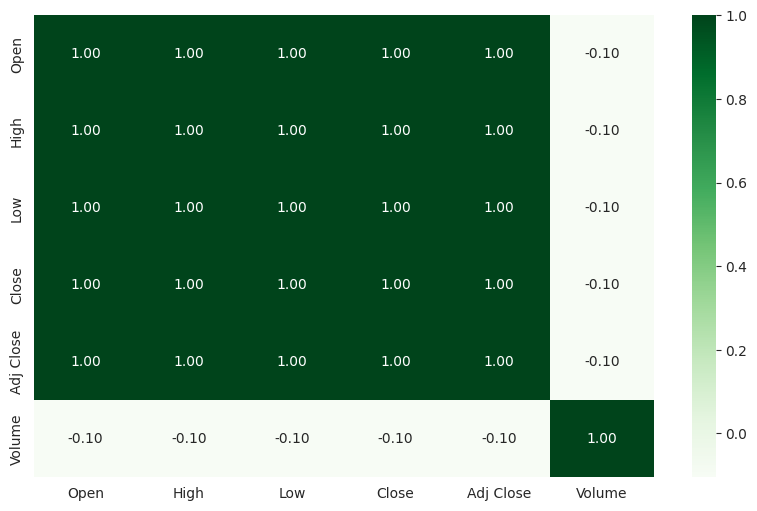

In [9]:
# Lets Visualise the Correlation Matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), fmt=".2f", annot=True, cmap='Greens')
plt.show()

### Results
- The Opening,High, Low, closing and Adj closing all stokes have a Perfectly Posistive Correlation that is 1.
- The Volumne is having about .10 and .11 values againsts other variables since it does not encopasses cost rather how many trades can be made.

In [10]:
fig = px.line(df, y=["High","Low"],title="NVIDIA STOCK VALUES FOR HIGH AND LOW OVER TIME")

fig.update_layout(
    height=700, width=1300,
    xaxis_title='Date',
    yaxis_title='LOW/HIGH STOCK VALUES',
)

fig.show()

In [11]:
# lets see the above, since 2020 where covid started, how the low and high were
# showcases the effects as it is seen above, the stock was very volatile
fig2 = px.line(df["2020-01-01":], y=["High","Low"],title="NVIDIA STOCK VALUES FOR HIGH AND LOW SINCE 2020")
fig2.update_layout(
    height=700, width=1300,
    xaxis_title='Date',
    yaxis_title='LOW/HIGH STOCK VALUES',
)


fig2.show()

- On above, it is seen that High and Low stocks appears to have with a very small margin difference about 5% difference in the prices.
Since 2020, when covid affected most stock markers, NVIDIA stock wasn't really affected mostly and it was hit in 2022 with a downward trend before it started picking again in 2023.
- AAPle expriences the higher prices as at now with over 970 in value.
- The prices has raised almost 5 times since 2020.
- Most of these rise is majory attributed to the fact that during this covid period, most people kept themselves bussy by playing games/mining crypto which requires GPU that is provided with NVIDIA hence increase in price. Despite this, the rapid in increase since start of 2023 is attributed to the advancement on AI especially LLM models.

In [12]:
# lets investigate more about this


fig = px.area(df, y=["Open","Close"],title="Open and Close Stocks Over Time")
fig.update_layout(
    height=700, width=1300,
    xaxis_title='Date',
    yaxis_title='OPEN/CLOSE STOCK VALUES',
)

fig.show()

### Results.
- The margin between the OPEN and CLOSE has been increasing over time with a very large change being seen from the year 2016.

In [13]:
# for the last 4 years since 2020
fig = px.area(df, y=["Open","Close"], range_x=['2020-01-01','2024-05-22'],title="Open and Close Stocks Over Time for the Last 4 years")
fig.update_layout(
    height=700, width=1300,
    xaxis_title='Date',
    yaxis_title='LOW/HIGH STOCK VALUES',
)

fig.show()

In [14]:
fig = px.line(df, y=["Volume"],color_discrete_sequence=["darkred"], title="Stock Volume Over Time")
fig.update_layout(
    height=700, width=1300,
    xaxis_title='Date',
    yaxis_title='Stock Volume',
)

fig.show()

- As seen above, the max volume is slightly above 500M, the volume has had unstable movement over a period of time with between 2012 and 2016 having the low volumes while the rest have almost same.

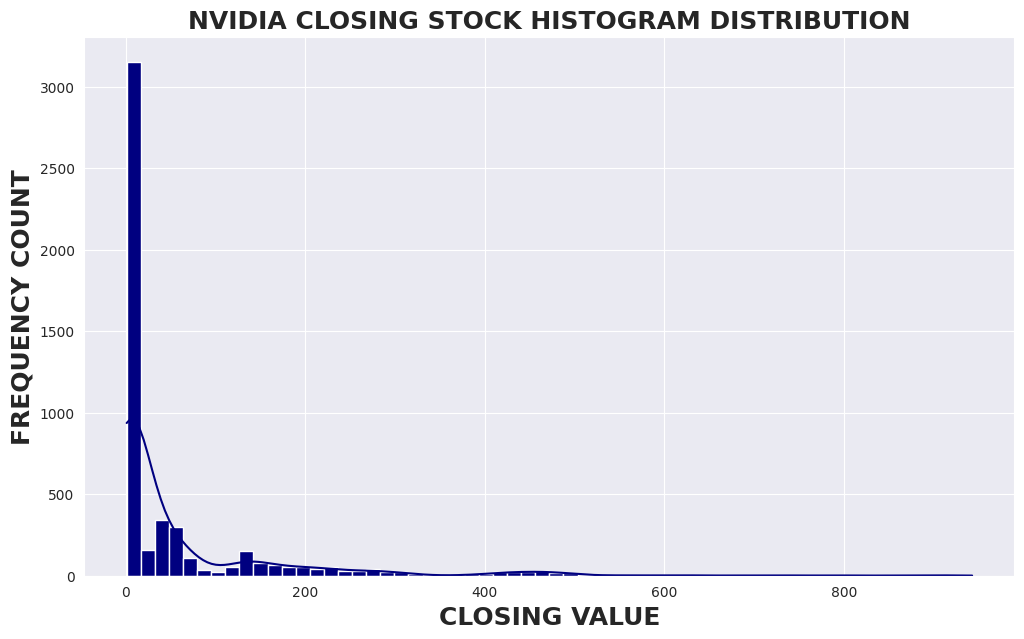

In [15]:
# PLOT CLOSING STOCK FOR NVIDIA
plt.figure(figsize=(12,7))
sns.histplot(df['Close'], kde =True, alpha=1, color = 'navy', bins=60)
plt.title("NVIDIA CLOSING STOCK HISTOGRAM DISTRIBUTION", fontweight='bold', fontsize=18)
plt.xlabel("CLOSING VALUE", fontweight='bold', fontsize=18)
plt.ylabel("FREQUENCY COUNT", fontweight='bold', fontsize=18)
plt.show()

Text(0, 0.5, 'FREQUENCY COUNT')

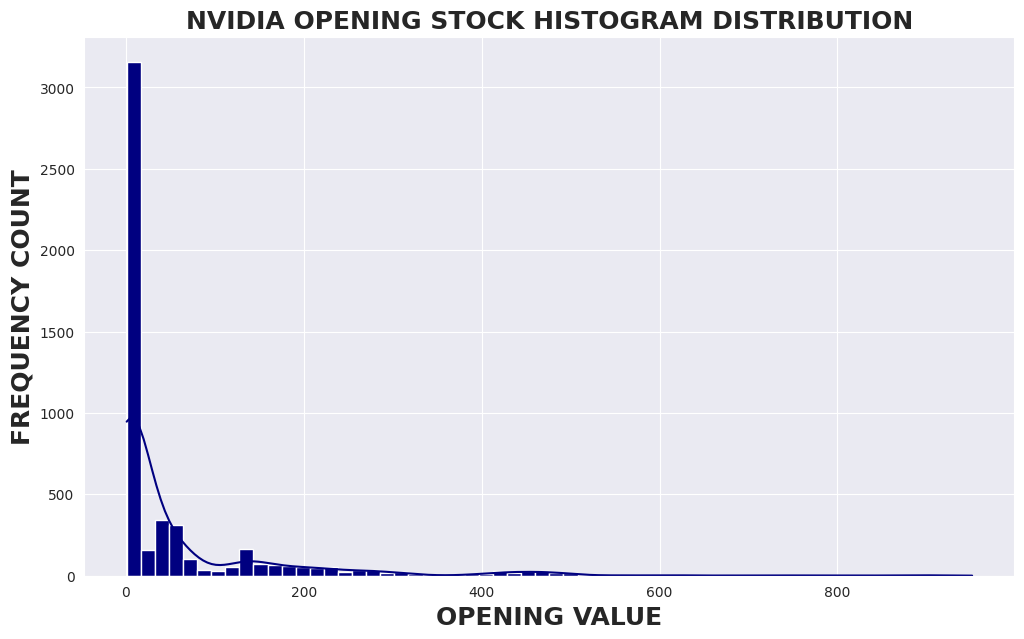

In [16]:
# PLOT OPENING STOCK FOR NVIDIA
plt.figure(figsize=(12,7))
sns.histplot(df['Open'], kde =True, alpha=1, color = 'navy', bins=60)
plt.title("NVIDIA OPENING STOCK HISTOGRAM DISTRIBUTION", fontweight='bold', fontsize=18)
plt.xlabel("OPENING VALUE", fontweight='bold', fontsize=18)
plt.ylabel("FREQUENCY COUNT", fontweight='bold', fontsize=18)

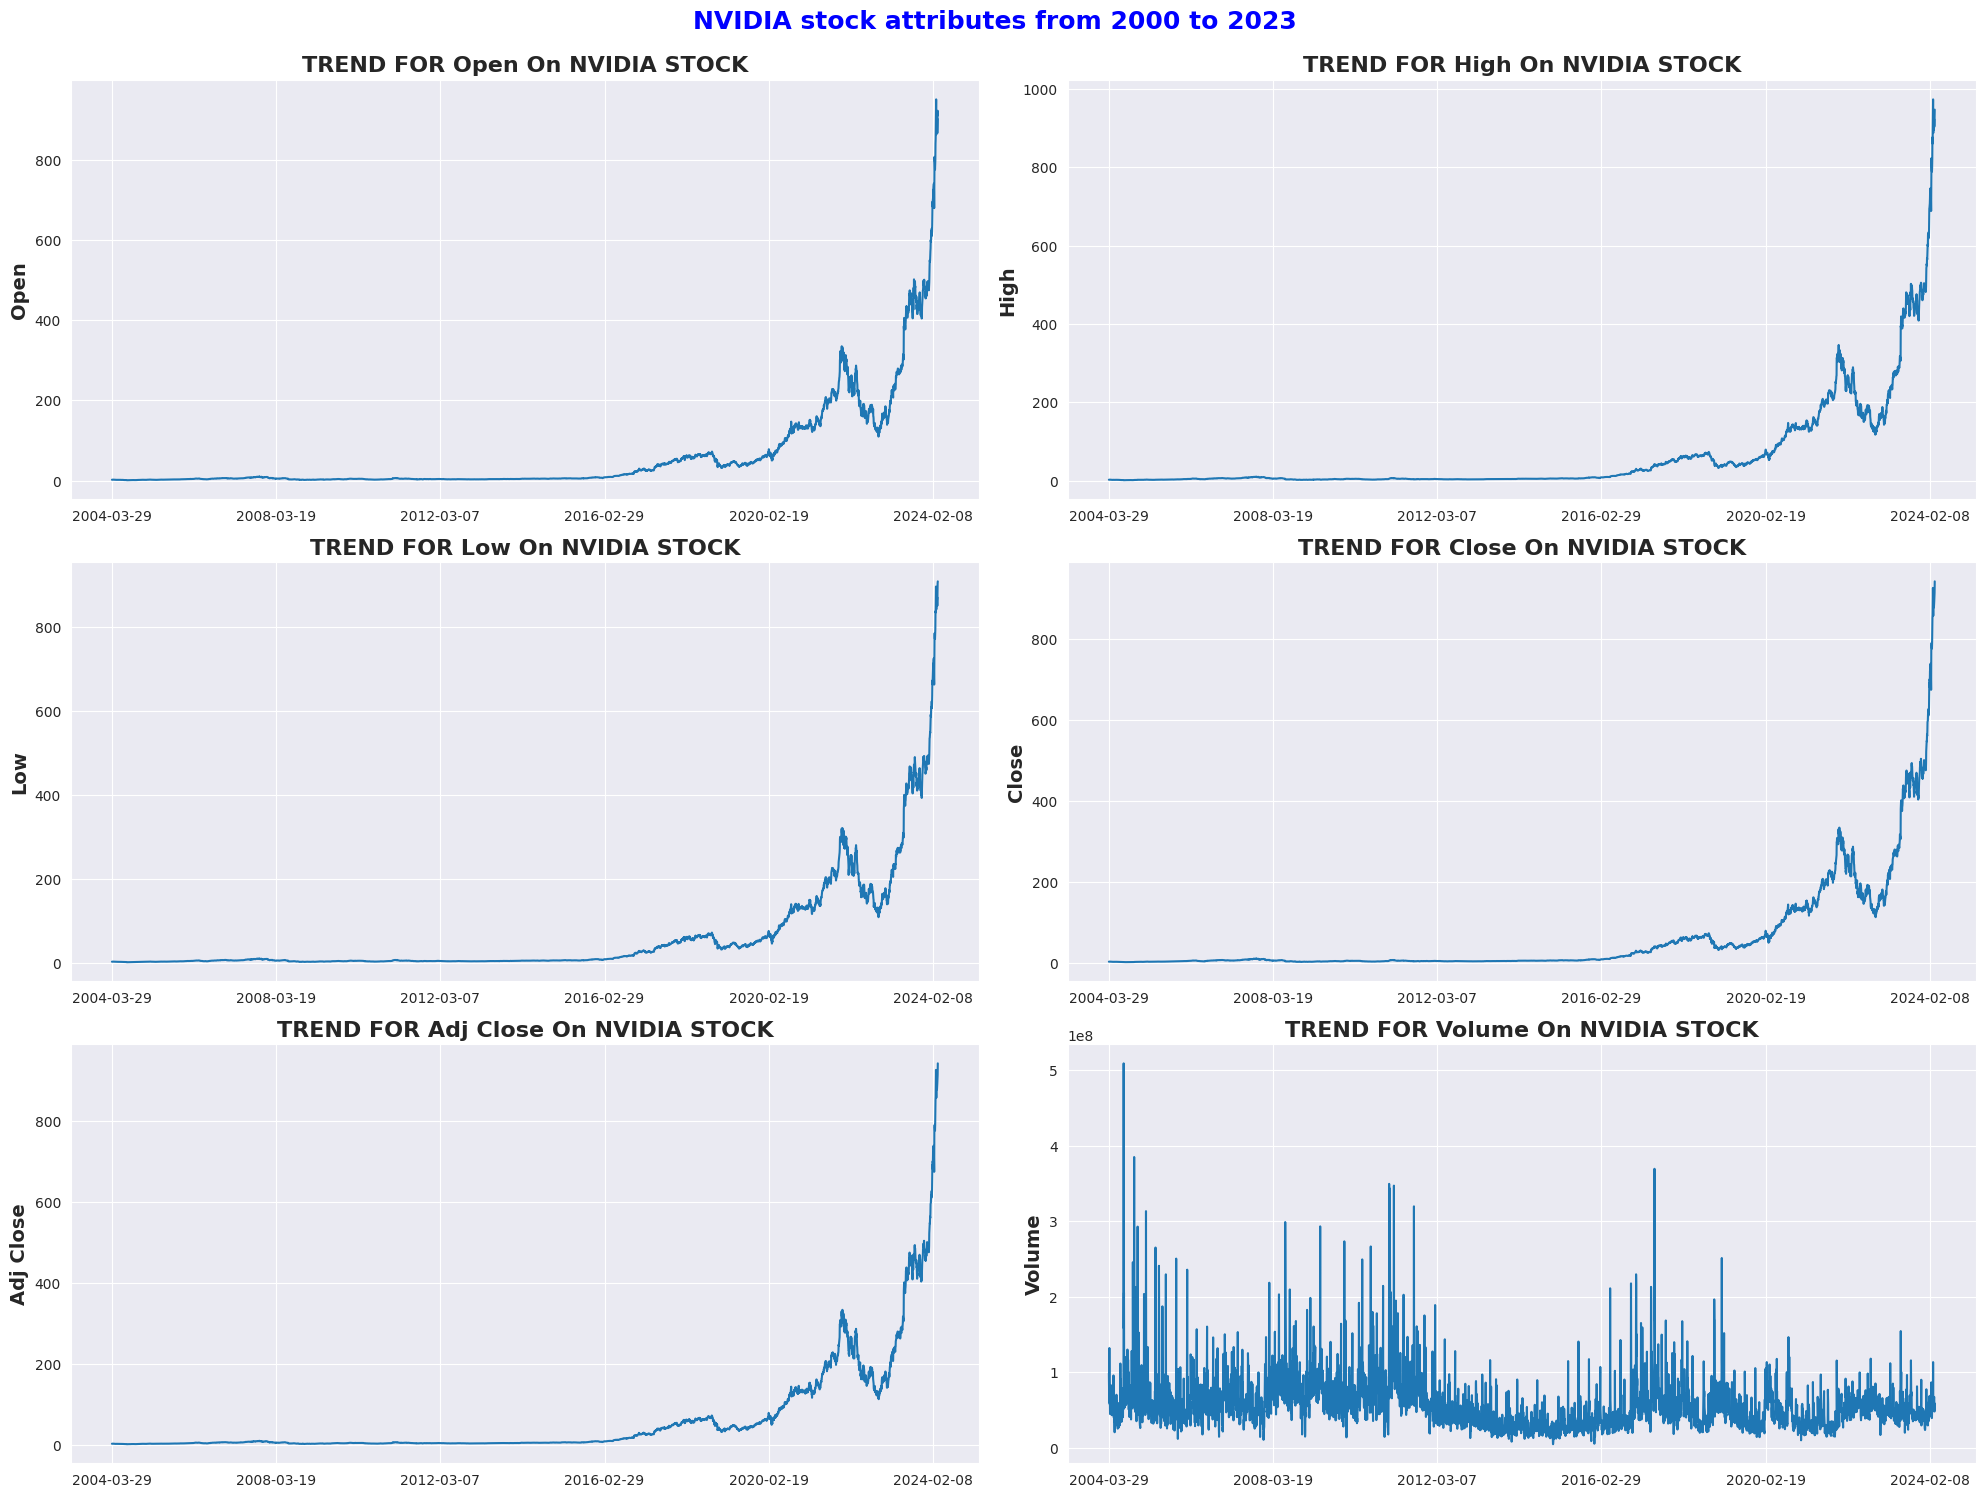

In [17]:
# comparison between open/close/high/low

plt.figure(figsize=(20, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)

COLS = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for i, col in enumerate(COLS):
    plt.subplot(3, 2, i+1)
    df[col].plot()
    plt.ylabel(col, fontweight='bold', fontsize=14)
    plt.xlabel(None)
    plt.title(f"TREND FOR {col} On NVIDIA STOCK", fontweight='bold', fontsize=16)
plt.suptitle('NVIDIA stock attributes from 2000 to 2023', y=0.995, fontsize=18, c='b', fontweight='bold')
plt.tight_layout()

### Moving Average(MA) of the NVIDIA stock
- The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price.
- The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.
- In this analysis, we are going to take 7,14,21 and 28 days(weekly basis)

In [18]:
ma_day = [7, 14, 21 ,28]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()


fig = px.line(
    df,
    y=['Adj Close', 'MA for 7 days', 'MA for 14 days','MA for 21 days', 'MA for 28 days'],
    title=" Market stock Analysis on Moving Averages of 7,14,21, and 28  On NVIDIA Stock from 2004 to 2024"
)

fig.update_layout(
    height=700, width=1300
)
fig.show()

### Daily Returns Analysis
- This involve checking on daily percentage change on Adjusted closing stock value.
- It helps identify how volatile the market was.

In [19]:
#### We'll use pct_change to find the percent change for each day
df['Daily Return'] = df['Adj Close'].pct_change()




fig = px.line(df, x=df.index, y='Daily Return',
              title='Market stock Analysis on  DAILY RETURNS On Stock from 2004 to 2024 for NVIDIA',
              labels={'Daily Return': 'Daily Return'},
              line_shape='linear',
              markers=True)


fig.update_layout(
    height=700, width=1300,
    xaxis_title='Date',
    yaxis_title='Daily Return',
)
fig.show()

### Results.
- From above, larger spikes suggests that the market was very volatile at that time.
- The NVIDIA stock market has not been having a longer period which was very volatile except some few instances as seen on the graph above.
- It experienced the lowest volatility in between 2010 and 2020

### TECHNICAL INDICATOR.
1. Bollinger bands: Bollinger Bands is used to define the prevailing high and low prices in a market to characterize the trading band of a financial instrument or commodity. Bollinger Bands are a volatility indicator. Bands are consists of Moving Average (MA) line, a upper band and lower band. The upper and lower bands are simply MA adding and subtracting standard deviation.
2. EMA: Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company's closing price are trending for a given amount of days. example for 4 days is price was 22,23 ,45,1 (the company crashed on 4th day) the average would be 23. Now 23 is a below average value so it gives us an idea that 45 was indeed just a fluke and that infact the company was always making losses EMA is calculated as: EMA(t)EMA(t0)=(1−α)EMA(t−1)+α p(t)=p(t0) where α=1L+1 and length of window is α=2M+1 I used the ewm(exponential weighted mean ) function to calculate ema.
3. Momentum: Momentum is perhaps the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset.



- The formula for momentum is:

    - Momentum=V−Vx where:
    - V=Latest price
    - Vx=Closing price
    - x=Number of days ago

- Link:
    - https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/
    - https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861

In [20]:
#function to generate feature technical indicators
def get_technical_indicators(df):
    # Create 7 and 21 days Moving Average
    df['ma7'] = df['Close'].rolling(window = 7).mean()
    df['ma21'] = df['Close'].rolling(window = 21).mean()
    #Create MACD
    df['26ema'] = df['Close'].ewm(span=26).mean()
    df['12ema'] = df['Close'].ewm(span=12).mean()
    df['MACD'] = (df['12ema']-df['26ema'])
    #Create Bollinger Bands
    df['20sd'] = df['Close'].rolling(window = 20).std()
    df['upper_band'] = (df['Close'].rolling(window = 20).mean()) + (df['20sd']*2)
    df['lower_band'] = (df['Close'].rolling(window = 20).mean()) - (df['20sd']*2)
    #Create Exponential moving average
    df['ema'] = df['Close'].ewm(com=0.5).mean()
    #Create Momentum
    df['momentum'] = (df['Close']/100)-1
    return df
# call the function on all 4 dataset


nvidia_tech = get_technical_indicators(df)

In [21]:
# function to plot these indicators
def plot_technical_indicators(df, last_days, stock_name):
    plt.figure(figsize=(16, 10), dpi=100)
    df = df.iloc[-last_days:, :]
    x_ = range(3, df.shape[0])
    x_ =list(df.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(df['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(df['Close'],label='Closing Price', color='b')
    plt.plot(df['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(df['upper_band'],label='Upper Band', color='c')
    plt.plot(df['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, df['lower_band'], df['upper_band'], alpha=0.35)
    plt.title('Technical indicators for NVIDIA - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    shape_0 = df.shape[0]
    xmacd_ = shape_0-last_days

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(df['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(df['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

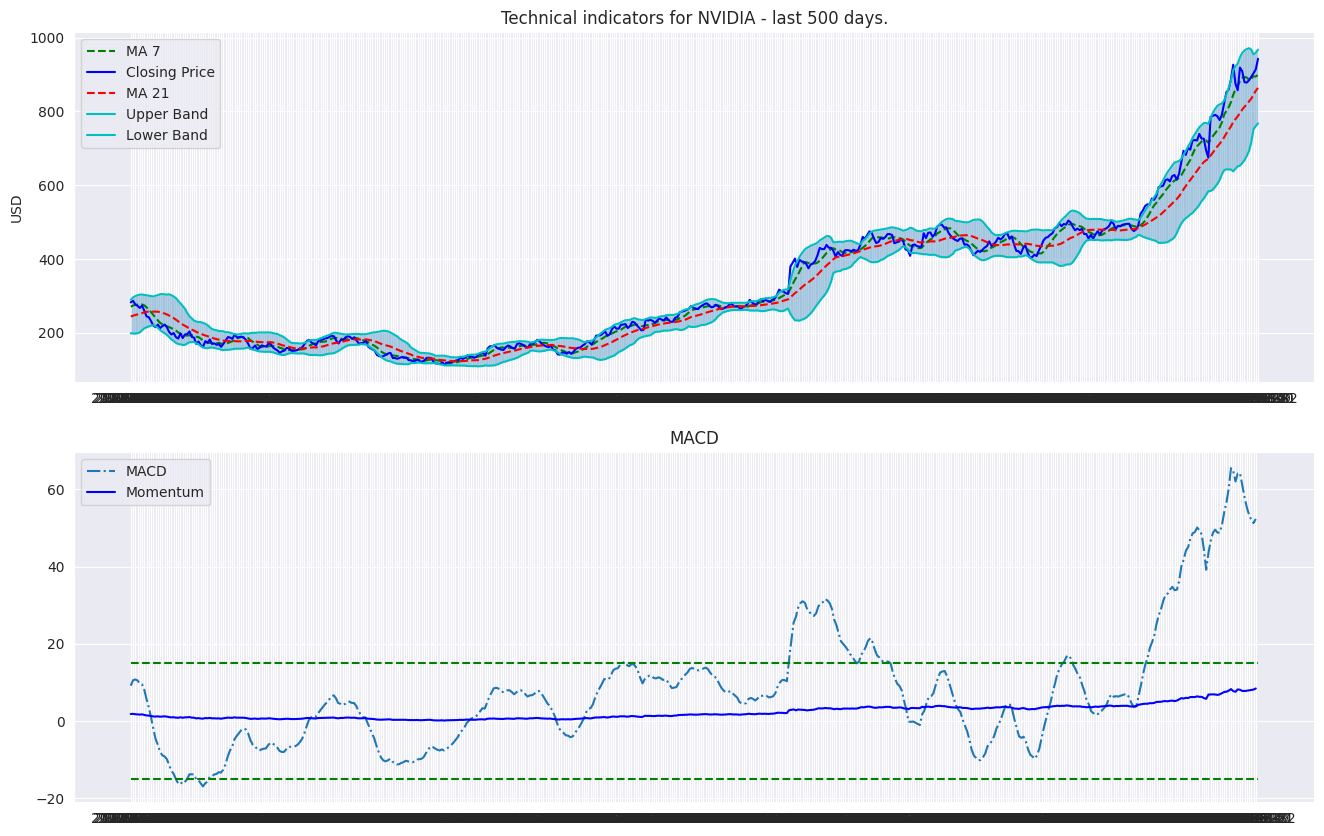

In [22]:
# # PLot Stock  for the last 1 and half Years
plot_technical_indicators(nvidia_tech, 500, "NVIDIA")



### Machine Learning and Stationarity Analysis

- From this part, we conduct a thorough analysis on stationarity of time series data followed by applying traditional time series models such as ARIMA and SARIMAX. These models will serve as benchmarks for comparison with deep learning models, specifically GRU and LSTM models.

#### Stationarity Analysis
We begin by analyzing the stationarity of the time series data. This involves various techniques such as:
- Log transformation: Applying log transformation to stabilize variance.
- Decomposition: Decomposing the time series into trend, seasonal, and residual components to identify underlying patterns.

#### Traditional Time Series Models
After conducting stationarity analysis, we proceed with implementing traditional time series models:
- ARIMA (AutoRegressive Integrated Moving Average): A classical linear model that combines autoregression, differencing, and moving average.
- SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables): An extension of ARIMA that incorporates seasonal components and exogenous variables.

These traditional models will serve as a benchmark for evaluating the performance of deep learning models.

#### Deep Learning Models
Once the benchmark models are established, we explore deep learning models:
- GRU (Gated Recurrent Unit): A type of recurrent neural network (RNN) architecture suitable for sequential data processing.
- LSTM (Long Short-Term Memory): Another variant of RNN designed to better capture long-term dependencies in sequential data.

By comparing the performance of traditional time series models with deep learning models, we aim to determine the effectiveness of each approach in modeling the time series data.



In [23]:
# Get the Time Series Column to be used for Analysis
ts = df['Close']

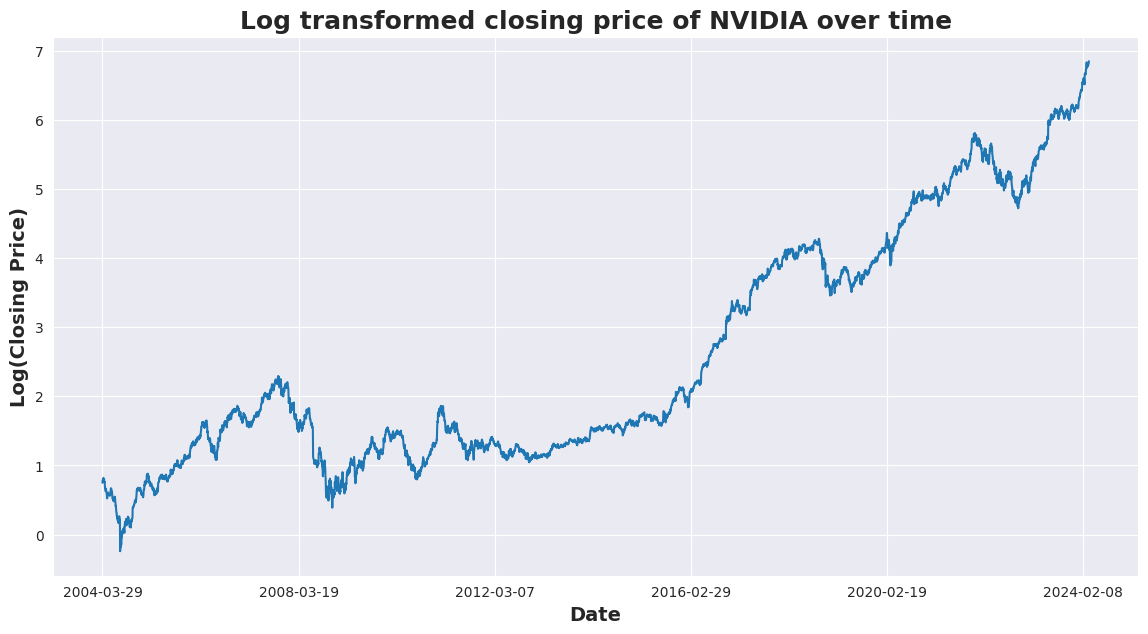

In [24]:
# Apply the log transformation to the `Close` column and
# Plot the log transformed closing price of Google over time
plt.figure(figsize=(14,7))
np.log(df['Close']).plot()
plt.xlabel('Date' , fontweight='bold', fontsize=14)
plt.ylabel('Log(Closing Price)', fontweight='bold', fontsize=14)
plt.title('Log transformed closing price of NVIDIA over time', fontweight='bold', fontsize=18)
plt.show()

### Observation
- The variability is reduced when log transformatio is applied unlike for original dataset
- From Here, I will be doing test for stationality.
More reference is done from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/


### Augmented Dickey-Fuller test (ADF TEST)
- This test part of the assumption of the null hypotesis that a unit root exists in a autoregressive model, otherwise, it doesn't. The importance of this test lies on abvoiding sparious regressions, so the model fits the data as much as possible.
- The graph below shows how mean and standard deviation variate over time, in fact the standard deviation varies a little it's enough to reject he null hypotesis.
- The Augmented Dickey-Fuller test says that if the p-value is below of one critical values, then we can't reject the null hypotesis, meaning that the model has a unit root.
- As Dickey-Fuller test says, our data is under 5% (0.05) critical value or p-value, giving a 90% of certainty that our data is stationarity

In [25]:
#checking stationality
def check_stationary(timeseries):
    '''
    defining  the rolling statistics on seven days basis ...weekly
    '''
    rol_mean =  timeseries.rolling(window=7,center=False).mean()
    rol_std = timeseries.rolling(window=7,center=False).std()
    '''
    plot rolling statistics
    '''
    plt.figure(figsize=(14,7))
    timeseries.plot(color='blue',label='Original Ts')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label = 'Rolling Std')
    plt.xlabel('DATETIME  ', fontsize=14, fontweight='bold')
    plt.ylabel('Stock Level', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.title('Rolling Mean And Standard Deviation',fontsize=14, fontweight='bold')
    plt.show(block=False)

In [26]:
#checking p-values and other stats using adfulller method and stationary..
# Note the data is more stationary as p-values is more to zero
from statsmodels.tsa.stattools import adfuller as ad
def check_stationary_adfuller(data):
    print("\n\nAdfuller Method")
    ad_test = ad(data , autolag = "AIC")
    ad_res = pd.Series(ad_test[0:4] , index = ["Test Statistic", "p-value" ,"#Lags Used" , "Number of Observation Used" ])
    for key , value in ad_test[4].items():
        print(f"Critical Value {key}   {value}\n")
    print(ad_res)

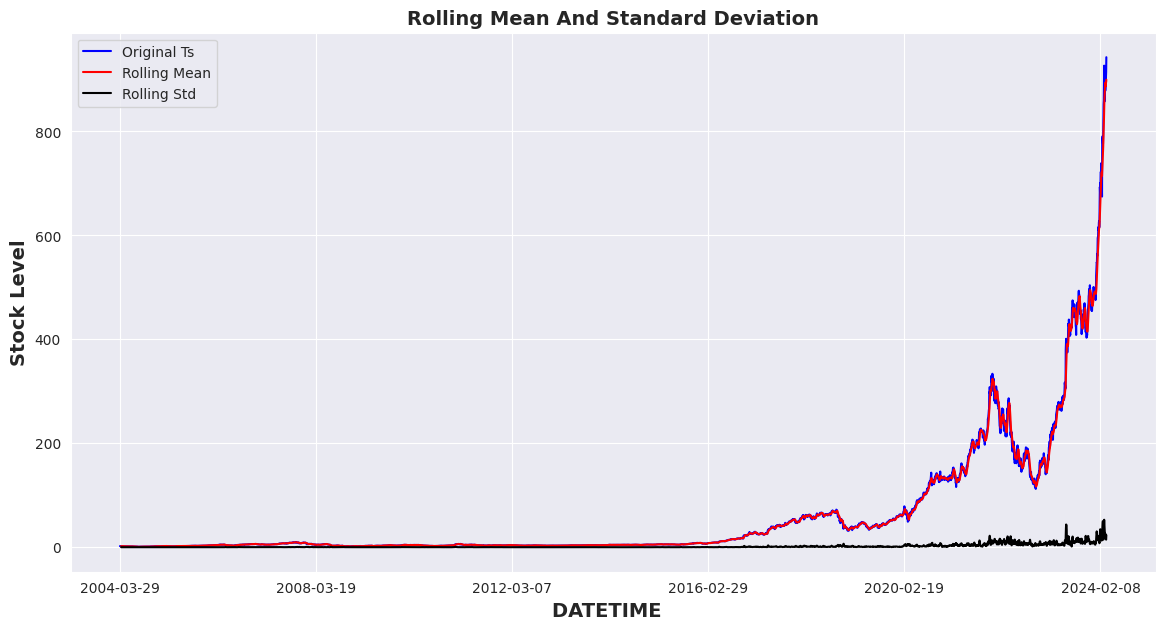



Adfuller Method
Critical Value 1%   -3.431659055967043

Critical Value 5%   -2.862118461132801

Critical Value 10%   -2.5670779155711902

Test Statistic                   5.02035
p-value                          1.00000
#Lags Used                      32.00000
Number of Observation Used    4998.00000
dtype: float64


In [27]:
#lets run the function on cases
check_stationary(df['Close'])
check_stationary_adfuller(df['Close'])

### Observation.
- From the above, we can be able to see that the p value is very large hence the data is not stationary.
- We next try Log transfromation

### Perfom Log Transformation
#### Time Series Trend.
- Trend can help to indicate whether the series is up or donw and we can be able to directly know the component that is affecting it. This component will help us know the direction of the series. At first we need to remove trends.
- TO deal with trend we can use MA, Decomposition, Transformations ect to find the best results.
- In order to estimate the trend is not easy since it shows non-stationary series. We will compaire diffrent methods like Log Transformations

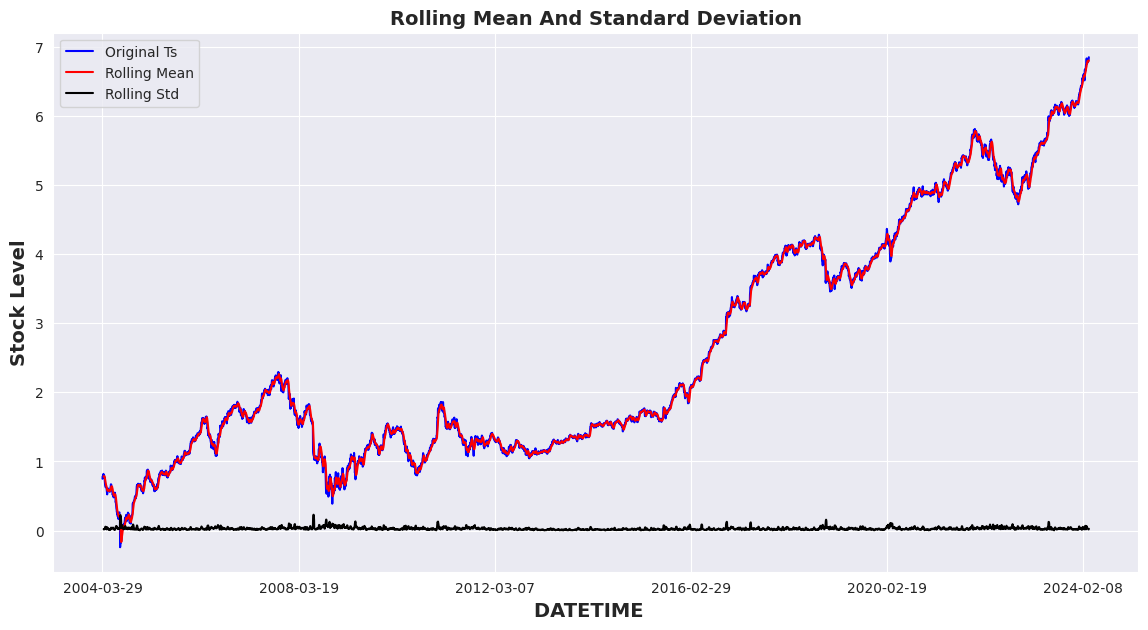



Adfuller Method
Critical Value 1%   -3.4316548765428174

Critical Value 5%   -2.8621166146845334

Critical Value 10%   -2.5670769326348926

Test Statistic                   1.208513
p-value                          0.996044
#Lags Used                      16.000000
Number of Observation Used    5014.000000
dtype: float64


In [28]:
# Perfom On log Transformation
check_stationary(np.log(df['Close']))
check_stationary_adfuller(np.log(df['Close']))

### Observation.
- Its still large although it has reduced to about 0.99. Also the curve has some stationarity
- The goal is having the p-value as small as possible below 0.05(5%)


- In the next step, we perfom the same thing but in this case shift the time series.

### SHIFT ON TIMESERIES

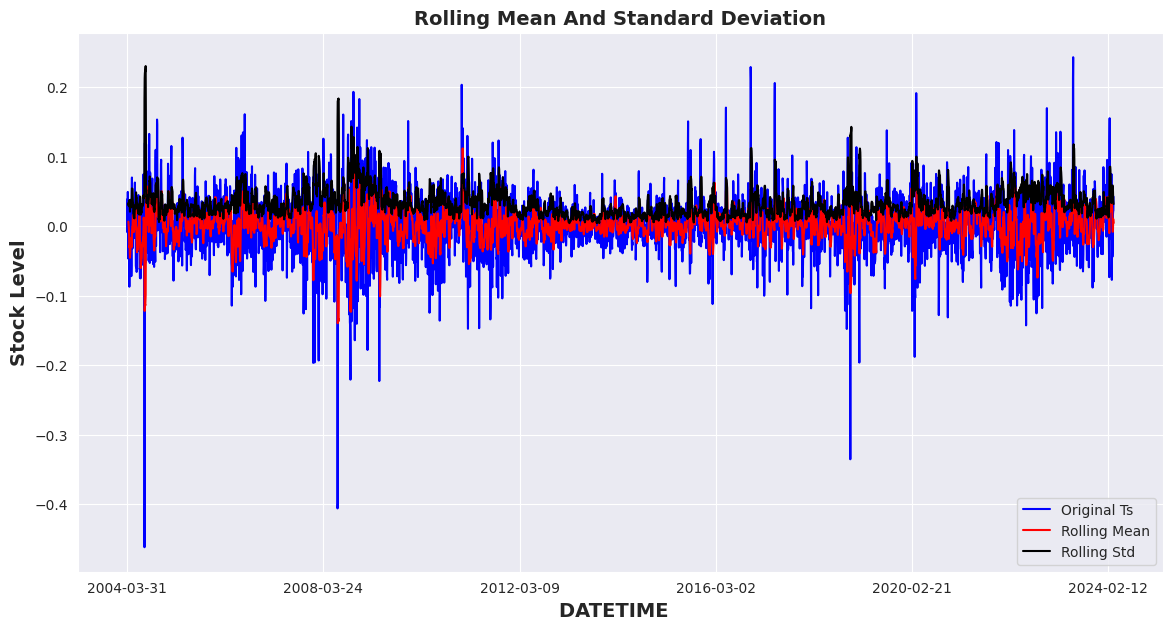



Adfuller Method
Critical Value 1%   -3.4316595802782865

Critical Value 5%   -2.8621186927706463

Critical Value 10%   -2.567078038881065

Test Statistic               -1.144409e+01
p-value                       6.078196e-21
#Lags Used                    3.200000e+01
Number of Observation Used    4.996000e+03
dtype: float64


In [29]:
# We perfom the Shift By Two Days
ts_close_log_shift = (np.log(df["Close"]) - np.log(df["Close"]).shift(2)).dropna()
check_stationary(ts_close_log_shift)
check_stationary_adfuller(ts_close_log_shift)

### Observation
- We have approached the stationality since the p-value is greatly approaching zero.
- The curve can be seen with the stationality and also p-value is less than 0.05





### Decomposing
- To use ARIMA models, lets try decomposing techniques.
- Decomposing is a technique referered to remove trend and sesonal components of time serie.
- For practicity, the time serie wouldn't be differencing, so graphics will show all components.
- As mentioned, seasonal decompose is the fastest way to remove trend and seasonality components from a time serie to becoming it stationary.

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

# monthly(4 weeks decomposition)
decomposition = seasonal_decompose(np.log(df['Close']), period=28, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

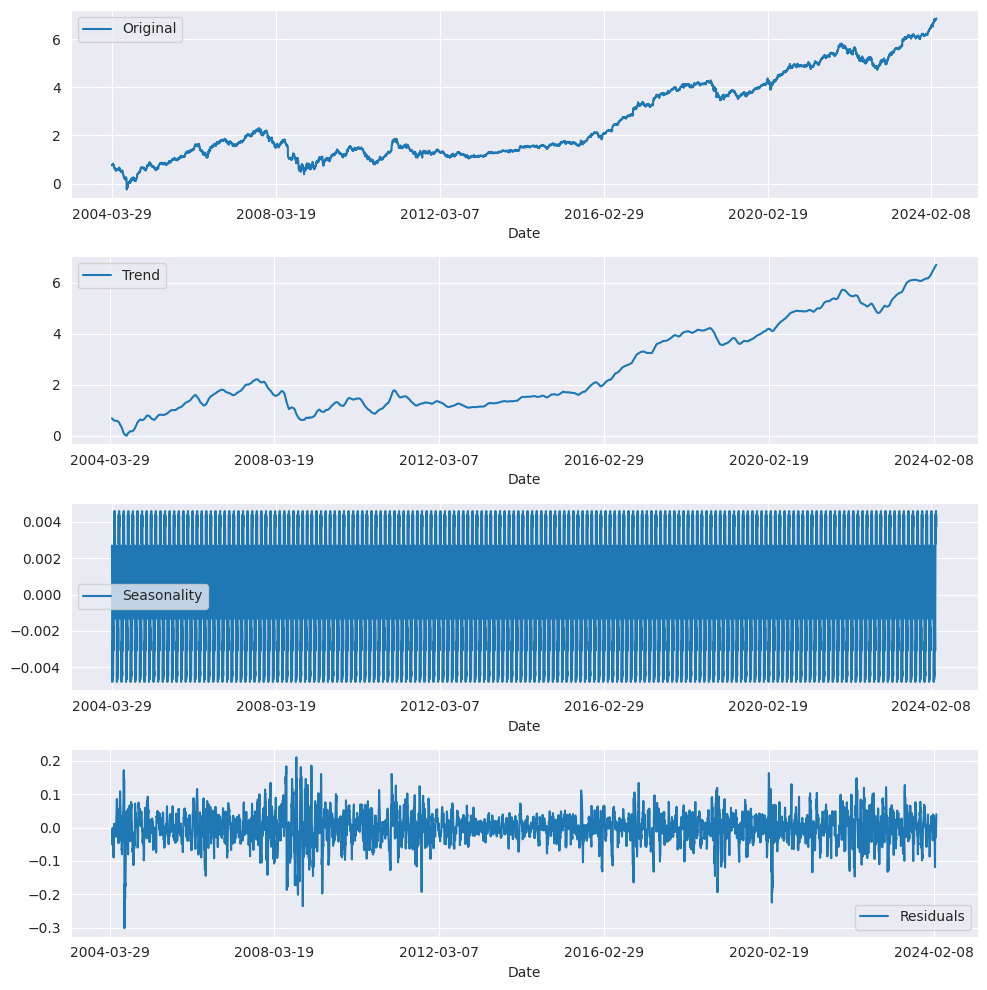

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(411)
np.log(df['Close']).plot(label="Original")
plt.legend(loc='best')
plt.subplot(412)
trend.plot(label="Trend")
plt.legend(loc='best')
plt.subplot(413)
seasonal.plot(label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
residual.plot(label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- The results of the test proof that the residual of the serie is stationary by comparing the test statistic value it's under 1% critical value, meaning we have 99% of confidence that the serie is stationary.



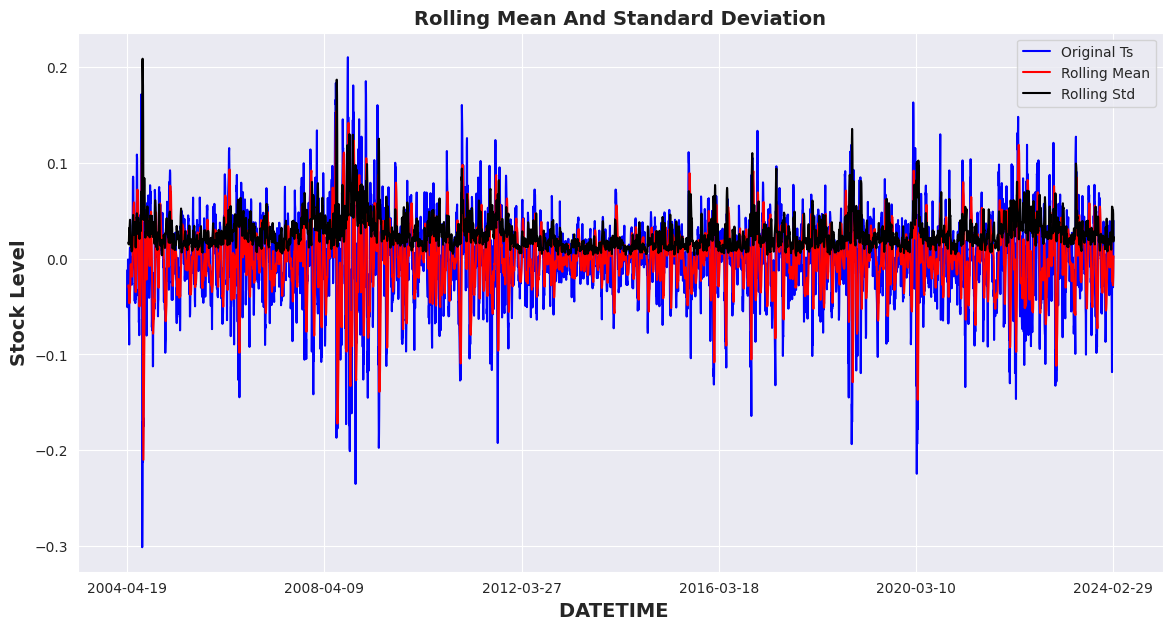



Adfuller Method
Critical Value 1%   -3.4316664347445838

Critical Value 5%   -2.862121721032689

Critical Value 10%   -2.5670796509438927

Test Statistic               -1.764561e+01
p-value                       3.741022e-30
#Lags Used                    3.200000e+01
Number of Observation Used    4.970000e+03
dtype: float64


In [32]:
ts_decompose = residual
# ts_decompose = ts_close_log_shift
ts_decompose.dropna(inplace=True)
check_stationary(ts_decompose)
check_stationary_adfuller(ts_decompose)

### Forecasting Time Series USING ARIMA MODELS
- Now since we have achieved stationarity in models, before moving to deep learning based, lets try the older models
- Once the serie is stationary, forecasting can be done. The ARIMA model has non-seasonal part, but it can handle seasonal data. Selecting the best model implies analize autocorrelation function and partial autocorrelation function. - Also, please note the following rules.
    - If PACF shows "a sharp cutoff and/or the lag-1 autocorrelation is positive, then consider adding one or more AR terms to the model".
    - If ACF shows "a sharp cutoff and/or the lag-1 autocorrelation is negative, then consider adding an MA term to the model."

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = ARIMA(ts_decompose, order=(1, 0, 0))
res = model.fit()

print('ARIMA RMSE: %.6f'% np.sqrt(sum((res.fittedvalues-ts_decompose)**2)/len(df['Close'])))
print('ARIMA R2: %.6f'% r2_score(ts_decompose, res.fittedvalues))
print('ARIMA MSE: %.6f'% mse(ts_decompose,  res.fittedvalues))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA RMSE: 0.028714
ARIMA R2: 0.612103
ARIMA MSE: 0.000829


Text(0.5, 1.0, 'ARIMA model')

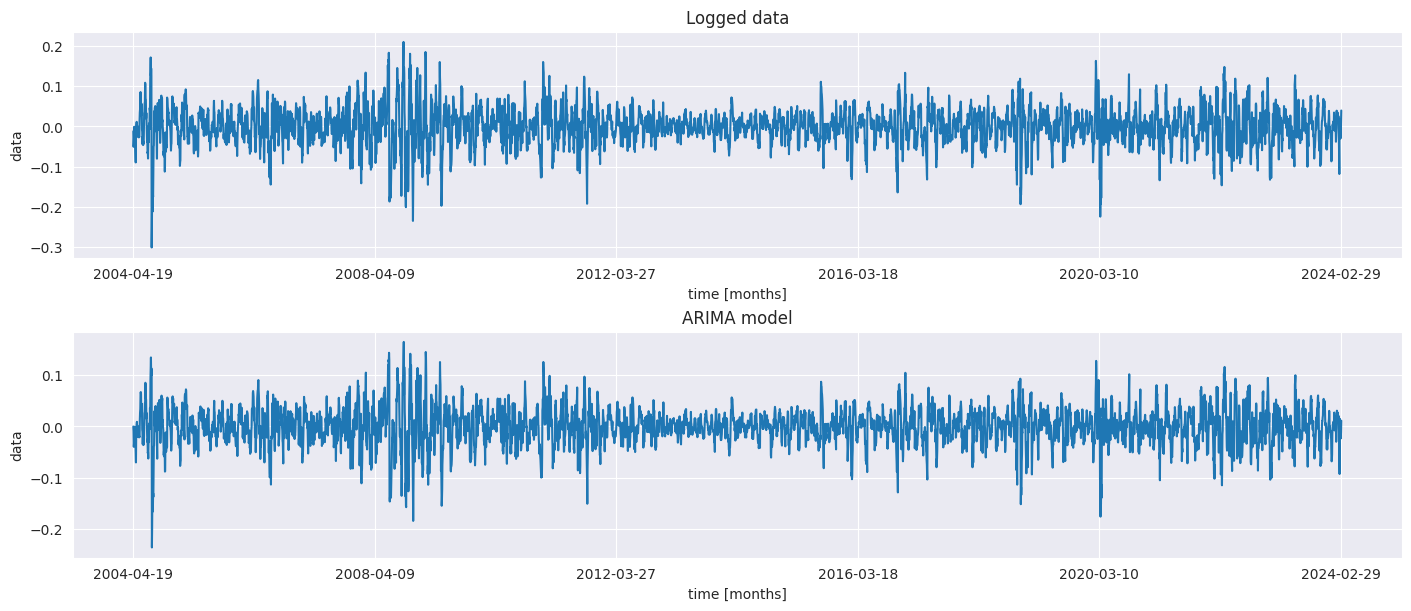

In [34]:
# Raw time serie
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(14,6))
gs = gridspec.GridSpec(2, 1, figure=fig)
ax = fig.add_subplot(gs[0, :])
ts_decompose.plot(ax=ax)
ax.set_xlabel('time [months]')
ax.set_ylabel('data')
ax.set_title('Logged data')


ax2 = fig.add_subplot(gs[1, :])
res.fittedvalues.plot(ax=ax2)
ax2.set_xlabel('time [months]')
ax2.set_ylabel('data')
ax2.set_title('ARIMA model')

### SARIMAX Models
- SARIMAX model is an extended version of ARIMA considering a seasonal component. It's compound of p , d and q parameters, as ARIMA model, but it includes a sesonal order P , D , Q and X component which is explanatory and may be used when the residual is expected to exhibit a seasonal trend or pattern.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



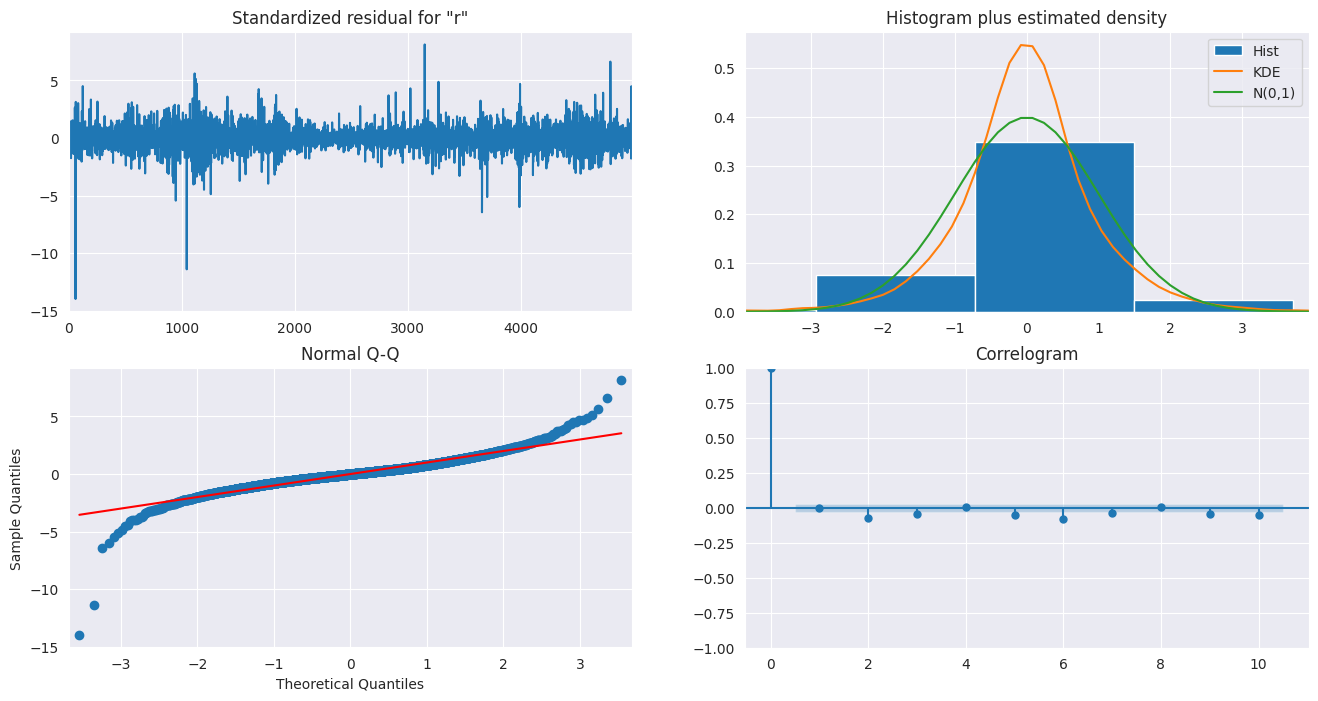

In [35]:
mod = SARIMAX(ts_decompose,
              order=(1,1,0), seasonal_order=(3,0,3,4),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [36]:
# Generate predicted values using the fitted SARIMAX model
predicted_values = results.predict()

# Get the actual values of your time series data (ts_decompose)
actual_values = ts_decompose

# Calculate residuals
residuals = actual_values - predicted_values

print('SARIMAX RMSE: %.6f'% np.sqrt(sum((residuals)**2)/len(df['Close'])))
print('SARIMAX MSE: %.6f'% mse(actual_values, predicted_values))
print('SARIMAX R2: %.6f'% r2_score(actual_values, predicted_values))

SARIMAX RMSE: 0.030034
SARIMAX MSE: 0.000907
SARIMAX R2: 0.575606


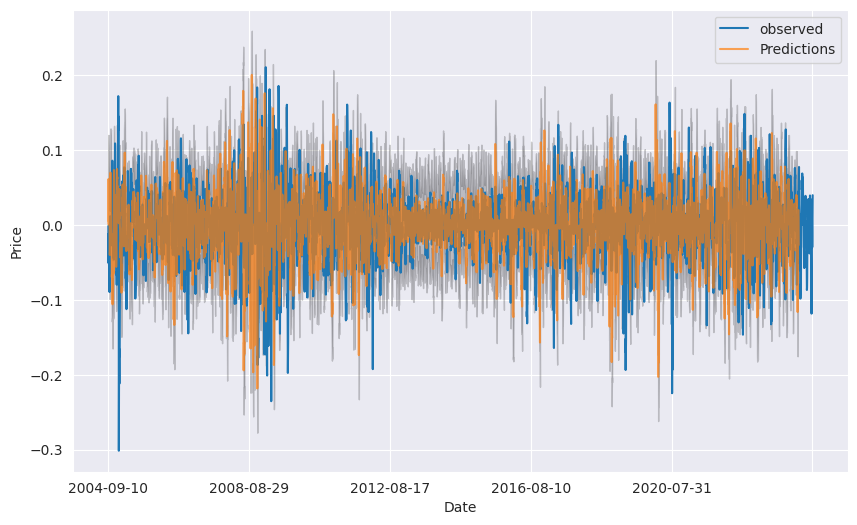

In [37]:
start_forecast = 100
pred = results.get_prediction(start=start_forecast, dynamic=False)
pred_ci = pred.conf_int()


plt.figure(figsize=(10,6))
ax = ts_decompose.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

### Results
- ARIMA model has it advantage over SARIMAX, it easier to implement and finding out its parameter that fits better the data, but it can't deal with seasonal data as well as SARIMAX. While SARIMAX fits better, it's more complicated to spot the correct parameters.
- In the results above, based on R2 and RMSE scores, its is seen that ARIMA perfoms slighghtly better than SARIMAX

### DEEP LEARNING BASED MODELS  (LSTM AND GRU).

#### GRU Model:
- The Gated Recurrent Unit (GRU) is a type of recurrent neural network that performs the same role as the more complex Long Short-Term Memory (LSTM) network, but with fewer gates and weights, making it simpler. Unlike the LSTM, the GRU only has two gates, which means it lacks the output gate, making it unable to control the memory content. The update gate manages the flow of information from the previous activation, as well as new information, while the reset gate is included in the candidate activation.
<img src='https://d2l.ai/_images/gru-1.svg'></img>




### Data Scaling.
- As from the ealier data precheck, It was observe that there was a very big margin interms of standard deviations meaning values are far apart, i.e In 2004, the value was ranging in 2 while currently its over 900.
- Training a model with this data would results into a bias where the model will treat a large value positively than a small value.
- To overcome this issue, the value from the closing column are going to be scaled using minmaxScaler algorithm which will scale all values in a small range of between -1 and 1.
- Only data from 2021 will be used for this part

In [38]:
# set seed fo reproductivity

seed = 2024
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)


In [39]:
df_copy = df.loc["2021-01-01":]

In [40]:
# scale the daya
scaler = MinMaxScaler(feature_range=(-1, 1))

# fit the scaler
scaler.fit(df_copy.Close.values.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [41]:
scaled_data = scaler.transform(df_copy.Close.values.reshape(-1,1))
scaled_data.shape

(810, 1)

### Data Spliting
- The models need to be validated and evaluated after each traiing,
- To do thism below is a function that perfoms data spliting. We are going to use loopback to create more features.
- These loopback looks like new features and acts as sequences

In [42]:
def train_test_split_sequencer(data, seq_number, test_size_pct=0.2):
    array_data = data
    res = []
    seq_number = seq_number+1
    #create the possible seq length
    for index in range(len(array_data) - seq_number):
        res.append(array_data[index: index + seq_number])

    res = np.array(res);
    #-.2 is used for testing and .8 for training by default
    test_size = int(np.round(test_size_pct*res.shape[0]));
    train_size = res.shape[0] - (test_size);
    return  (
        torch.from_numpy(res[:train_size,:-1,:]).type(torch.Tensor),
        torch.from_numpy(res[:train_size,-1,:]).type(torch.Tensor),
        torch.from_numpy(res[train_size:,:-1]).type(torch.Tensor),
        torch.from_numpy(res[train_size:,-1,:]).type(torch.Tensor)
    )

In [43]:
# test above
Xtrain, Ytrain, Xtest, Ytest = train_test_split_sequencer(scaled_data, seq_number=32)

# check the shapes
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

(torch.Size([622, 32, 1]),
 torch.Size([622, 1]),
 torch.Size([155, 32, 1]),
 torch.Size([155, 1]))

- Below is a Gru model Architecture

In [44]:
import torch
import torch.nn as nn


class CustomGRUNetwork(nn.Module):
    """
    customized GRU model architecture.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.1):
        super(CustomGRUNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # gru layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # rnn layer
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # full connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # create hidden states for gru
        h0_gru = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # get input through GRU layer
        out_gru, _ = self.gru(x, h0_gru.detach())

        # create hidden states for RNN
        h0_rnn = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # get output of GRU through RNN layer
        out_rnn, _ = self.rnn(out_gru, h0_rnn.detach())

        # get the output through fully connected layer
        out = self.fc(out_rnn[:, -1, :])
        return out



In [45]:
# define a function to do the training
DEFAULT_HIDDEN_UNITS = 16
DEFAULT_INPUT_DIM = 1
DEFAULT_OUTPUT_DIM = 1
DEFAULT_NUM_LAYERS = 8
DEFAULT_MAX_EPOCHS = 12
LR = 0.001
def train_ts_deep_learning_model(custom_model, training_data, testing_data,
                                input_dim=DEFAULT_INPUT_DIM,
                                output_dim=DEFAULT_OUTPUT_DIM,
                                num_layers=DEFAULT_NUM_LAYERS,
                                max_epochs=DEFAULT_MAX_EPOCHS,
                                num_hidden=DEFAULT_HIDDEN_UNITS,
                                lr = LR,
                                model_save_path = "best_gru_network.pth"
                               ):


    #keep track of the best perfomance in order to save the model
    best_r2_score = float('-inf')
    #define the model by calling the model passed with paremeters now
    model = custom_model(input_dim=input_dim, hidden_dim=num_hidden, output_dim=output_dim, num_layers=num_layers)
    #loss method
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"train_mse": [], "train_r2": [], "val_mse": [], "val_rmse": [], "val_r2": []}
    start_time = time.time()

    #training process
    for epoch_num in range(max_epochs):
        train_predictions = model(training_data[0])
        loss = criterion(train_predictions, training_data[1])

        # Validation
        val_predictions = model(testing_data[0]).detach().numpy()
        r2_val = r2_score(testing_data[1], val_predictions)
        mse_val = mse(testing_data[1], val_predictions, squared=False)
        rmse_val = mse(testing_data[1], val_predictions, squared=True)
        r2_train = r2_score(training_data[1], train_predictions.detach().numpy())
        train_mse = loss.item()

        if epoch_num % 5 == 0:
            print("Epoch ", epoch_num, f"Train_MSE: {train_mse:.5f} Train_R2: {r2_train:.5f}  Val_RMSE {rmse_val:.5f}  Val_MSE {mse_val:.5f}  val_R2_Score {r2_val:.5f}")
        history['train_mse'].append(train_mse)
        history['train_r2'].append(r2_train)
        history['val_mse'].append(mse_val)
        history['val_rmse'].append(rmse_val)
        history['val_r2'].append(r2_val)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if r2_val > best_r2_score:
            best_r2_score = r2_val
            torch.save(model.state_dict(), model_save_path)

    train_predictions = pd.DataFrame(scaler.inverse_transform(model(training_data[0]).detach().numpy()))
    test_predictions = original = pd.DataFrame(scaler.inverse_transform(model(testing_data[0]).detach().numpy()))

    training_time = time.time() - start_time
    print("Training time is : {}".format(training_time))
    print(f"BEST R2 score for Evaluation is {best_r2_score}")
    return model, train_predictions, test_predictions, history

In [46]:
# a function to plot historical metrics
def plot_loss_and_accuracy(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(22, 7))
    plt.suptitle(f"*********** {model_name} Evaluation Plots *************", fontsize=16, fontweight='bold')

    # Plot MSE
    axes[0].plot(history['train_mse'], color='red', label="Training MSE")
    axes[0].plot(history['val_mse'], color='blue', label="Validation MSE")
    axes[0].set_xlabel('Epochs', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('MSE', fontsize=13, fontweight='bold')
    axes[0].legend(['MSE Train', 'MSE Test'])
    axes[0].grid(True)

    # Plot R2
    axes[1].plot(history['train_r2'], color='red', label="Training R2")
    axes[1].plot(history['val_r2'], color='blue', label="Validation R2")
    axes[1].set_xlabel('Epochs', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('R2 Score', fontsize=13, fontweight='bold')
    axes[1].legend(['R2 Train', 'R2 Test'])
    axes[1].grid(True)

    axes[0].set_title(f"{model_name} Model MSE Loss Evaluation", color='black', fontsize=14, fontweight='bold')
    axes[1].set_title(f"{model_name}  R2 Score", color='black', fontsize=14, fontweight='bold')



In [47]:
# check them
def plot_predictions_vs_original(model_name, dataset_values, model, X, Y_true, set_type="Test "):
    fig = plt.figure(figsize=(20, 10))

    # Inverse transform Y_true and model predictions
    Y_true = pd.DataFrame(scaler.inverse_transform(Y_true.detach().numpy()))[0]
    Y_preds = pd.DataFrame(scaler.inverse_transform(model(X).detach().numpy()))[0]

    # Plot original data
    ax = sns.lineplot(x=range(len(Y_true)), y=Y_true, label=f"{set_type} Data", color='blue')
    # Plot model predictions
    ax = sns.lineplot(x=range(len(Y_preds)), y=Y_preds, label=f"{set_type} Predictions on {model_name} Network", color='red')

    # Calculate R2 score
    r2_score_val = np.absolute(r2_score(Y_true, Y_preds))

    # Set title and labels
    ax.set_title(f'{model_name} Stock Price Curves with R2: {r2_score_val:.4f}', size=14, fontweight='bold')
    ax.set_xlabel("Days", size=14)
    ax.set_ylabel("Cost ($)", size=14)
    ax.set_xticklabels('', size=10)

    plt.show()


In [48]:
# Function to evaluare the final Metrics perfomance

def get_perfomance(model, model_name, Xdata, Ydata, data_type="TEST "):
    yval = model(Xdata).detach().numpy()
    print(f"\nMetrics For {model_name} include the following on {data_type}")
    print(f"\tRMSE Score:  {np.absolute(mse(Ydata, yval, squared=True)):.4f}")
    print(f"\tMSE Score:  {np.absolute(mse(Ydata, yval, squared=False)):.4f}")
    print(f"\tR2 Score:  {np.absolute(r2_score(Ydata, yval)):.4f}\n")

In [49]:
# set the test models
model_gru2, train_set1, test_set1, history_gru1 = train_ts_deep_learning_model(
    CustomGRUNetwork,
    (Xtrain,Ytrain),
    (Xtest, Ytest),
    num_layers=4,
    max_epochs=200,
    num_hidden=32,
    model_save_path="best_gru_network.pth"
)

Epoch  0 Train_MSE: 0.87276 Train_R2: -21.62434  Val_RMSE 0.14180  Val_MSE 0.37657  val_R2_Score -0.14475
Epoch  5 Train_MSE: 0.23062 Train_R2: -4.97837  Val_RMSE 0.24562  Val_MSE 0.49560  val_R2_Score -0.98287
Epoch  10 Train_MSE: 0.05053 Train_R2: -0.30989  Val_RMSE 0.90623  Val_MSE 0.95196  val_R2_Score -6.31585
Epoch  15 Train_MSE: 0.09054 Train_R2: -1.34694  Val_RMSE 1.17023  Val_MSE 1.08177  val_R2_Score -8.44706
Epoch  20 Train_MSE: 0.04266 Train_R2: -0.10581  Val_RMSE 0.79278  Val_MSE 0.89038  val_R2_Score -5.39999
Epoch  25 Train_MSE: 0.05386 Train_R2: -0.39608  Val_RMSE 0.57211  Val_MSE 0.75638  val_R2_Score -3.61859
Epoch  30 Train_MSE: 0.04715 Train_R2: -0.22229  Val_RMSE 0.64221  Val_MSE 0.80138  val_R2_Score -4.18442
Epoch  35 Train_MSE: 0.04195 Train_R2: -0.08742  Val_RMSE 0.78010  Val_MSE 0.88323  val_R2_Score -5.29763
Epoch  40 Train_MSE: 0.04337 Train_R2: -0.12425  Val_RMSE 0.83326  Val_MSE 0.91283  val_R2_Score -5.72681
Epoch  45 Train_MSE: 0.03988 Train_R2: -0.03384

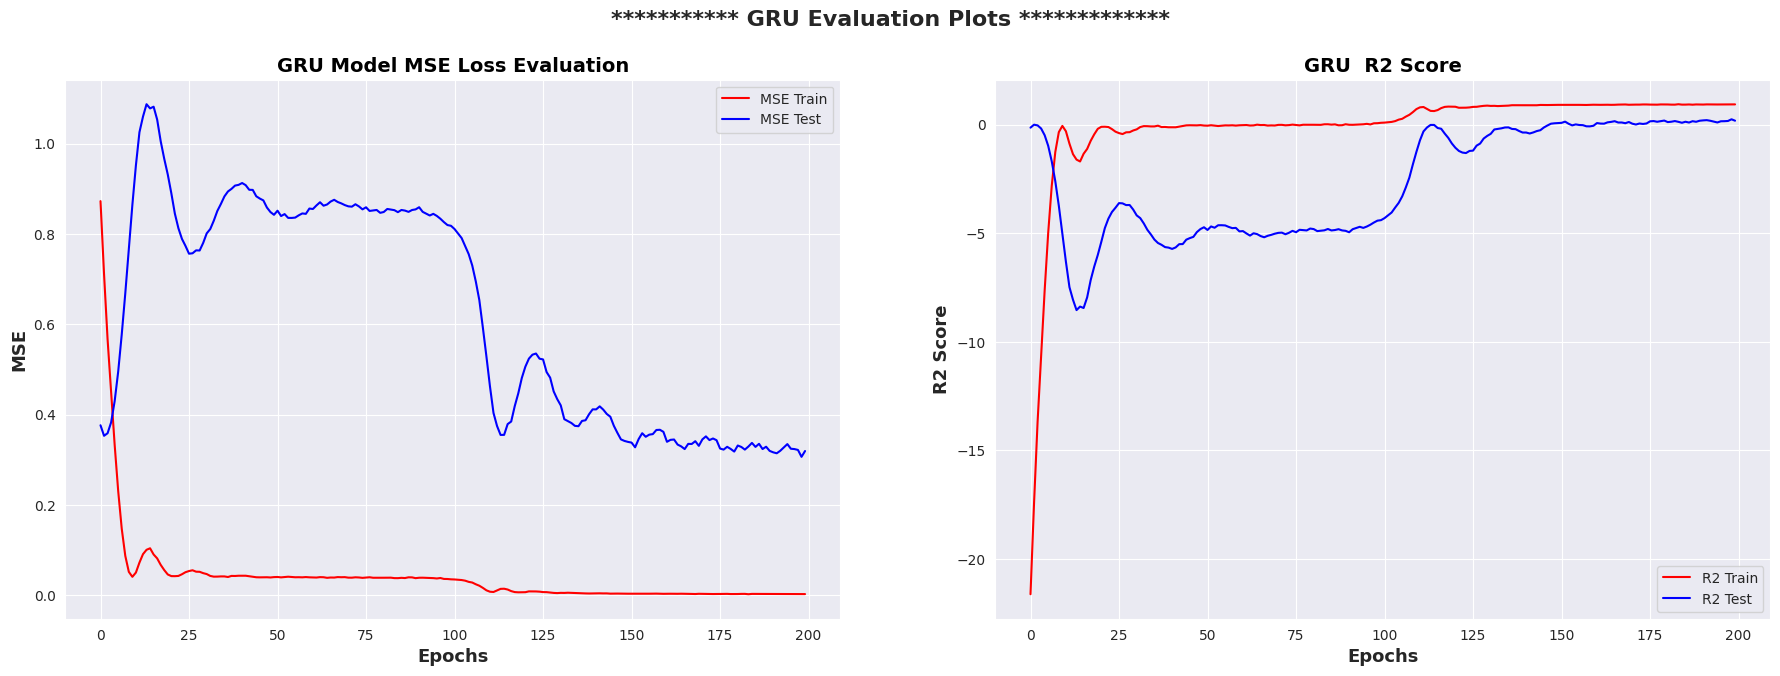

In [50]:
plot_loss_and_accuracy(history_gru1, "GRU")


In [51]:
# load the best trained model for rest
num_layers=4
num_hidden=32
input_dim =DEFAULT_INPUT_DIM
output_dim = DEFAULT_OUTPUT_DIM

best_gru_model = CustomGRUNetwork(input_dim=input_dim, hidden_dim=num_hidden, output_dim=output_dim, num_layers=num_layers)
best_gru_model.load_state_dict(torch.load('best_gru_network.pth'))

<All keys matched successfully>

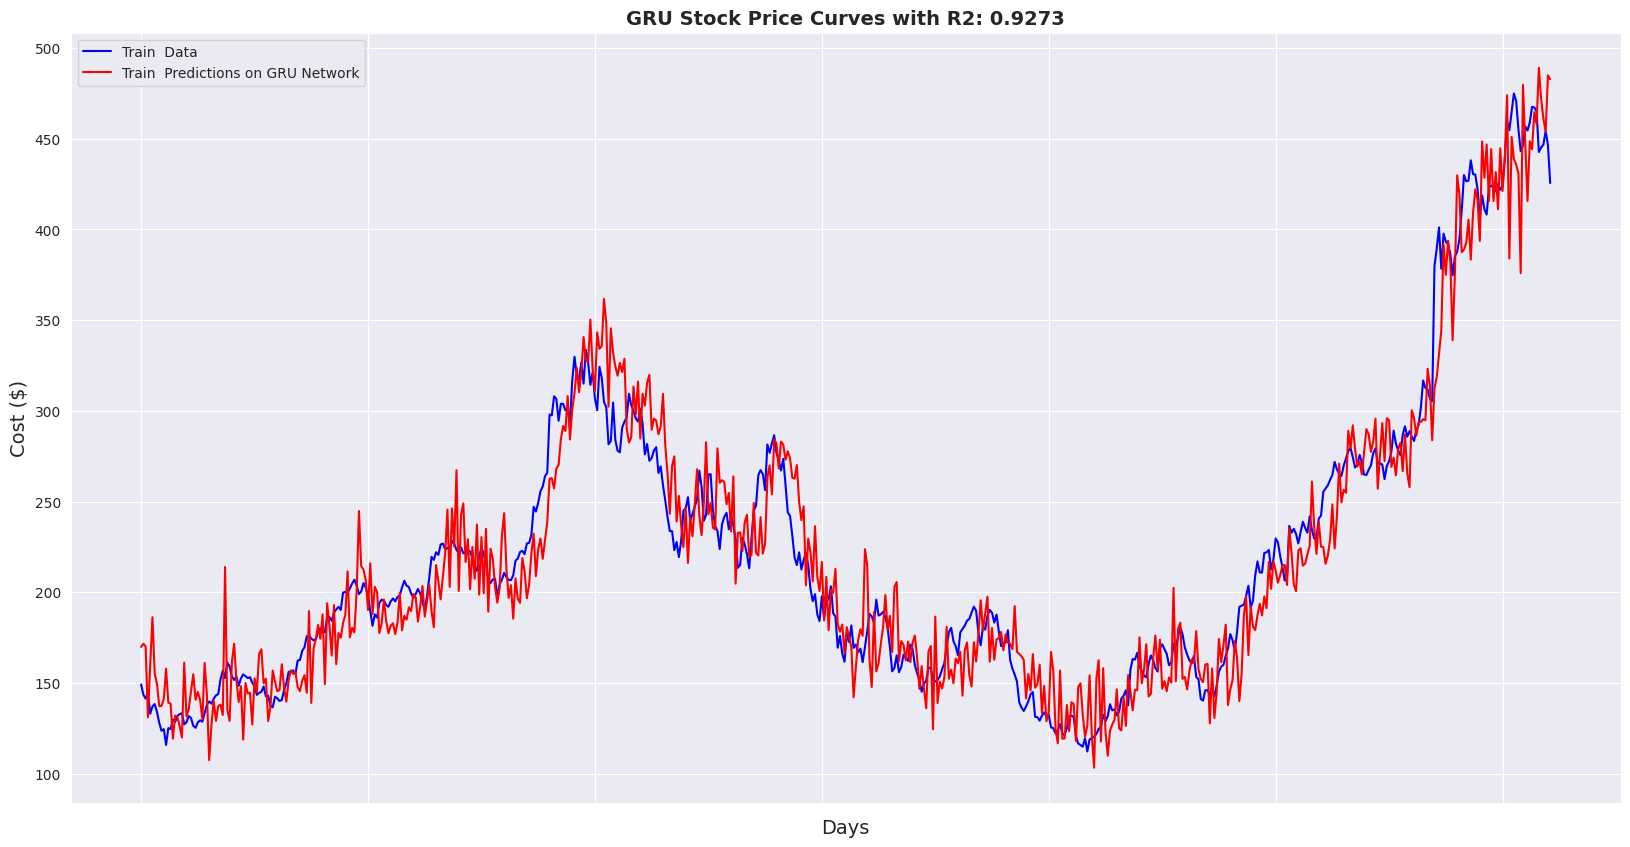

In [52]:
# Plot predictions on Train Data
plot_predictions_vs_original("GRU", train_set1, best_gru_model, Xtrain, Ytrain, "Train ")

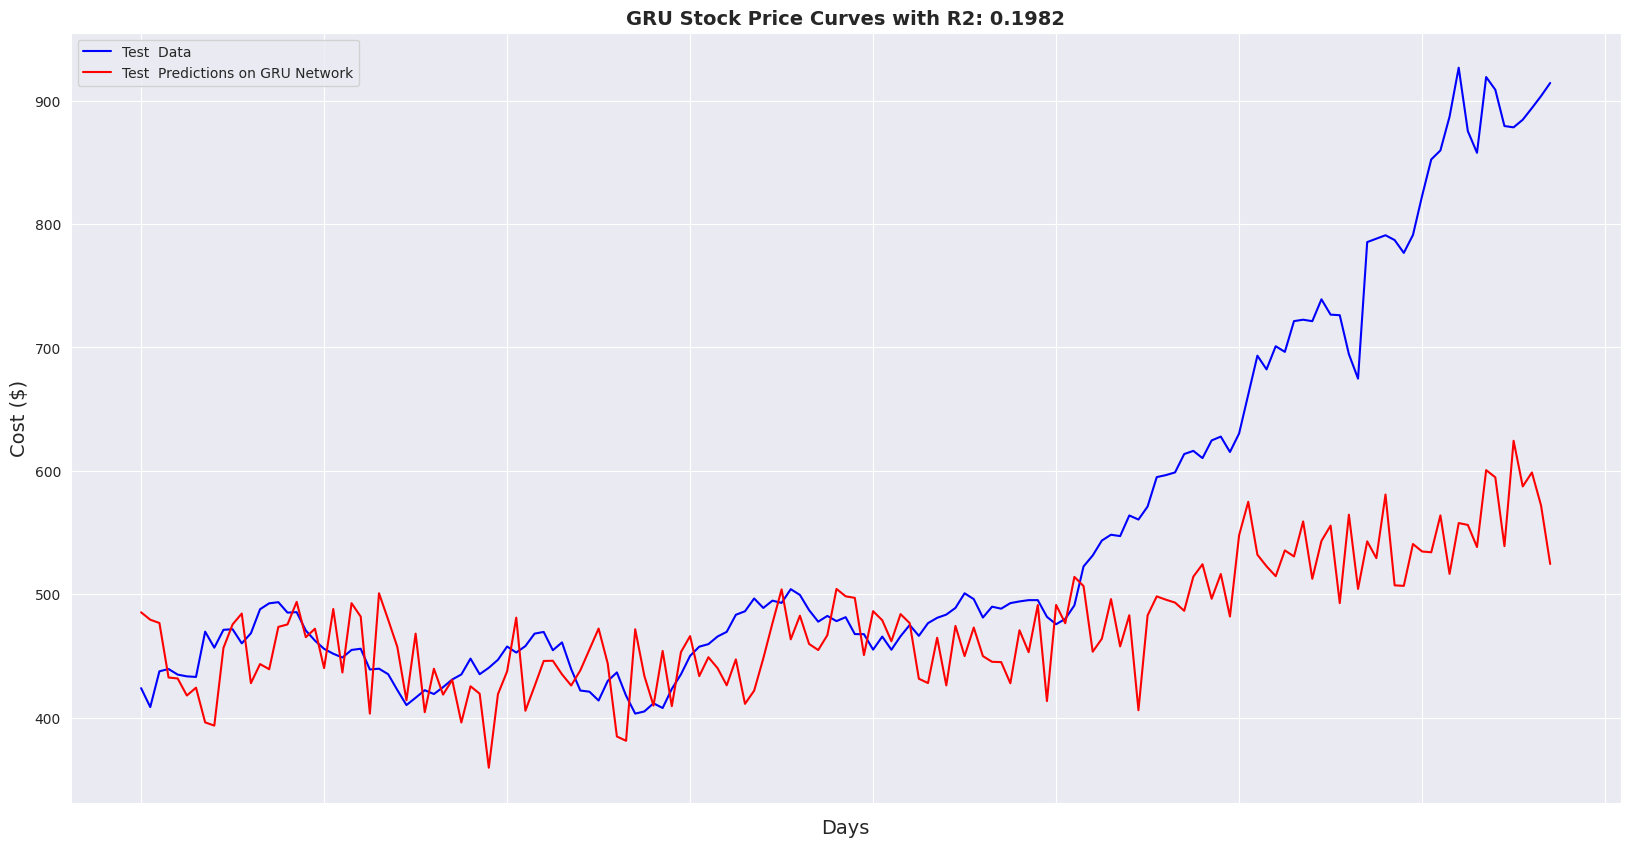

In [53]:
plot_predictions_vs_original("GRU", test_set1, best_gru_model, Xtest, Ytest)


In [54]:
# test the perfomance
get_perfomance(best_gru_model, "GRU Model", Xtest, Ytest)
get_perfomance(best_gru_model, "GRU Model", Xtrain, Ytrain, "TRAIN")


Metrics For GRU Model include the following on TEST 
	RMSE Score:  0.0961
	MSE Score:  0.3100
	R2 Score:  0.2241


Metrics For GRU Model include the following on TRAIN
	RMSE Score:  0.0032
	MSE Score:  0.0561
	R2 Score:  0.9183



### MODEL 2: LSTM MODEL



## LSTM?
- This (long short-term memory networks or LSTM) is used in the field of Deep Learning.
- It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images.
- This makes it very good in speech recognition, machine translation or any sequantial data, etc. LSTM is a special kind of RNN, which shows outstanding performance on a large variety of problems.

- The figure below shows an examples of its working

<center><img src = "https://miro.medium.com/max/1400/1*goJVQs-p9kgLODFNyhl9zA.gif" alt="LSTM aniamtion" width=700px></center>



In [55]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

class ArchitectureLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, drop_prob=0.1):
        super(ArchitectureLSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # rnn layer
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=drop_prob)

        # lstm layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=drop_prob)

        # fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden states for RNN
        h0_rnn = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # pass input through RNN layer
        out_rnn, _ = self.rnn(x, h0_rnn.detach())

        # init hidden states for LSTM
        h0_lstm = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0_lstm = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # pass input through LSTM layer
        out_lstm, _ = self.lstm(x, (h0_lstm.detach(), c0_lstm.detach()))

        # merge outputs from RNN and LSTM layers
        out_combined = torch.cat((out_rnn[:, -1, :], out_lstm[:, -1, :]), dim=1)

        # pass combined output through fully connected layer
        out = self.fc(out_combined)

        return out


In [56]:
model_lstm, train_set2, test_set2, history_lstm = train_ts_deep_learning_model(
    ArchitectureLSTMNet,
    (Xtrain,Ytrain),
    (Xtest, Ytest),
    num_layers=4,
    max_epochs=200,
    num_hidden=32,
    model_save_path="best_lstm_network.pth"
)

Epoch  0 Train_MSE: 0.50525 Train_R2: -12.09760  Val_RMSE 0.12565  Val_MSE 0.35448  val_R2_Score -0.01438
Epoch  5 Train_MSE: 0.12902 Train_R2: -2.34456  Val_RMSE 0.31978  Val_MSE 0.56549  val_R2_Score -1.58150
Epoch  10 Train_MSE: 0.04907 Train_R2: -0.27203  Val_RMSE 0.84147  Val_MSE 0.91732  val_R2_Score -5.79303
Epoch  15 Train_MSE: 0.06704 Train_R2: -0.73784  Val_RMSE 0.94646  Val_MSE 0.97286  val_R2_Score -6.64060
Epoch  20 Train_MSE: 0.03814 Train_R2: 0.01134  Val_RMSE 0.67052  Val_MSE 0.81885  val_R2_Score -4.41301
Epoch  25 Train_MSE: 0.04661 Train_R2: -0.20826  Val_RMSE 0.54914  Val_MSE 0.74104  val_R2_Score -3.43308
Epoch  30 Train_MSE: 0.03934 Train_R2: -0.01993  Val_RMSE 0.58976  Val_MSE 0.76796  val_R2_Score -3.76100
Epoch  35 Train_MSE: 0.03565 Train_R2: 0.07579  Val_RMSE 0.66203  Val_MSE 0.81365  val_R2_Score -4.34447
Epoch  40 Train_MSE: 0.03595 Train_R2: 0.06803  Val_RMSE 0.65828  Val_MSE 0.81134  val_R2_Score -4.31416
Epoch  45 Train_MSE: 0.03165 Train_R2: 0.17960  Va

In [57]:
# load the best lstm model
num_layers=4
num_hidden=32
input_dim =DEFAULT_INPUT_DIM
output_dim = DEFAULT_OUTPUT_DIM

best_lstm_model = ArchitectureLSTMNet(input_dim=input_dim, hidden_dim=num_hidden, output_dim=output_dim, num_layers=num_layers)
best_lstm_model.load_state_dict(torch.load('best_lstm_network.pth'))

<All keys matched successfully>

In [58]:
get_perfomance(best_lstm_model, "LSTM", Xtest, Ytest)
get_perfomance(best_lstm_model, "LSTM", Xtrain, Ytrain, "TRAIN")


Metrics For LSTM include the following on TEST 
	RMSE Score:  0.0628
	MSE Score:  0.2505
	R2 Score:  0.4933


Metrics For LSTM include the following on TRAIN
	RMSE Score:  0.0022
	MSE Score:  0.0471
	R2 Score:  0.9425



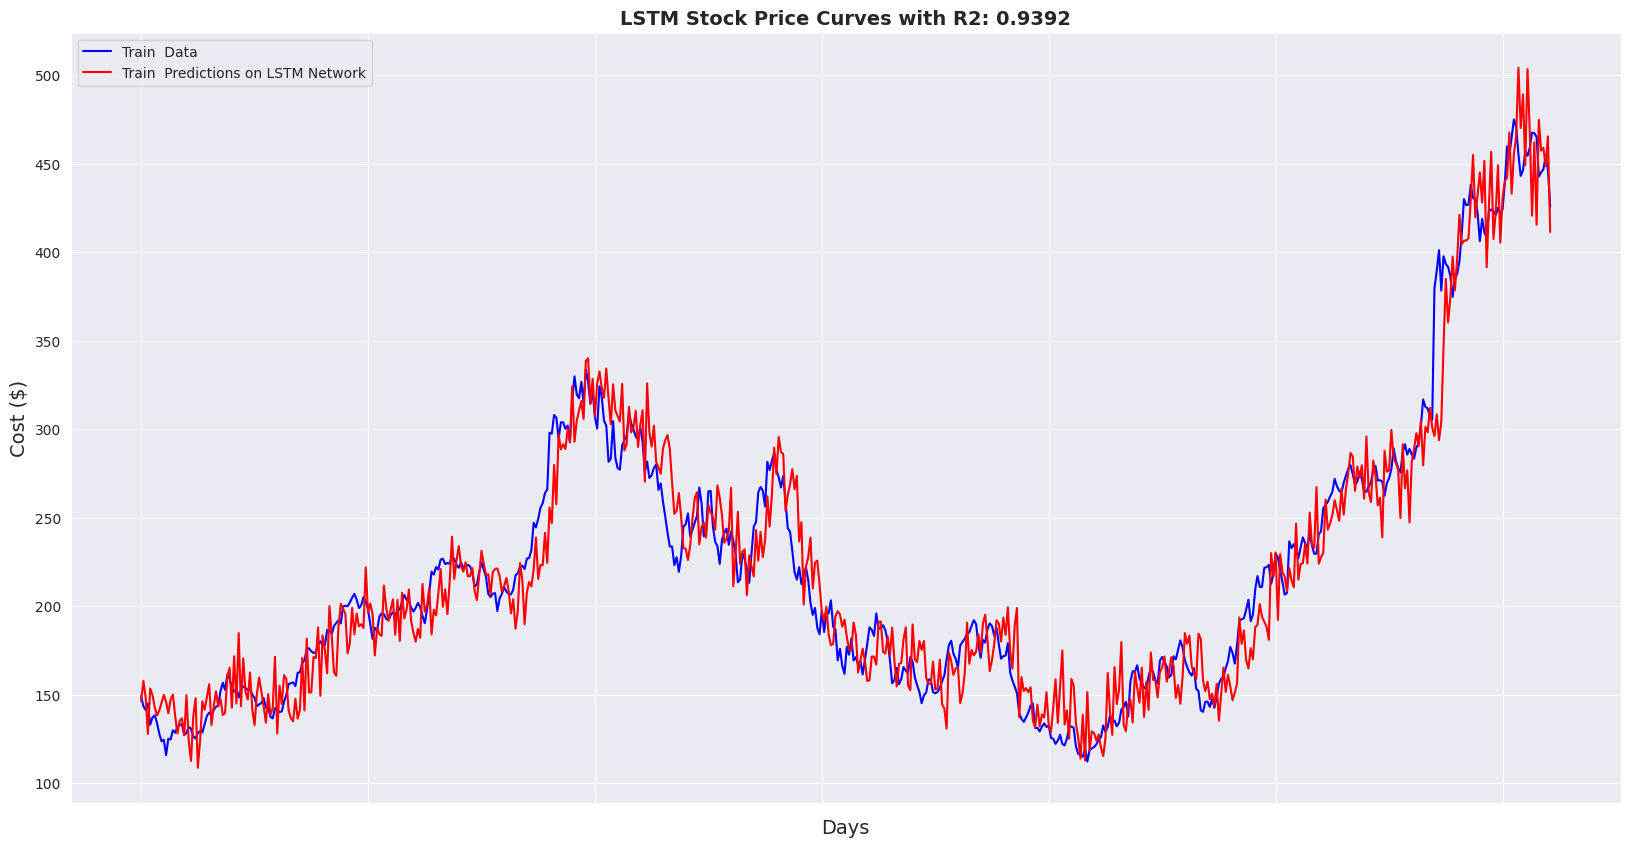

In [59]:
plot_predictions_vs_original("LSTM", train_set2, best_lstm_model, Xtrain, Ytrain, "Train ")

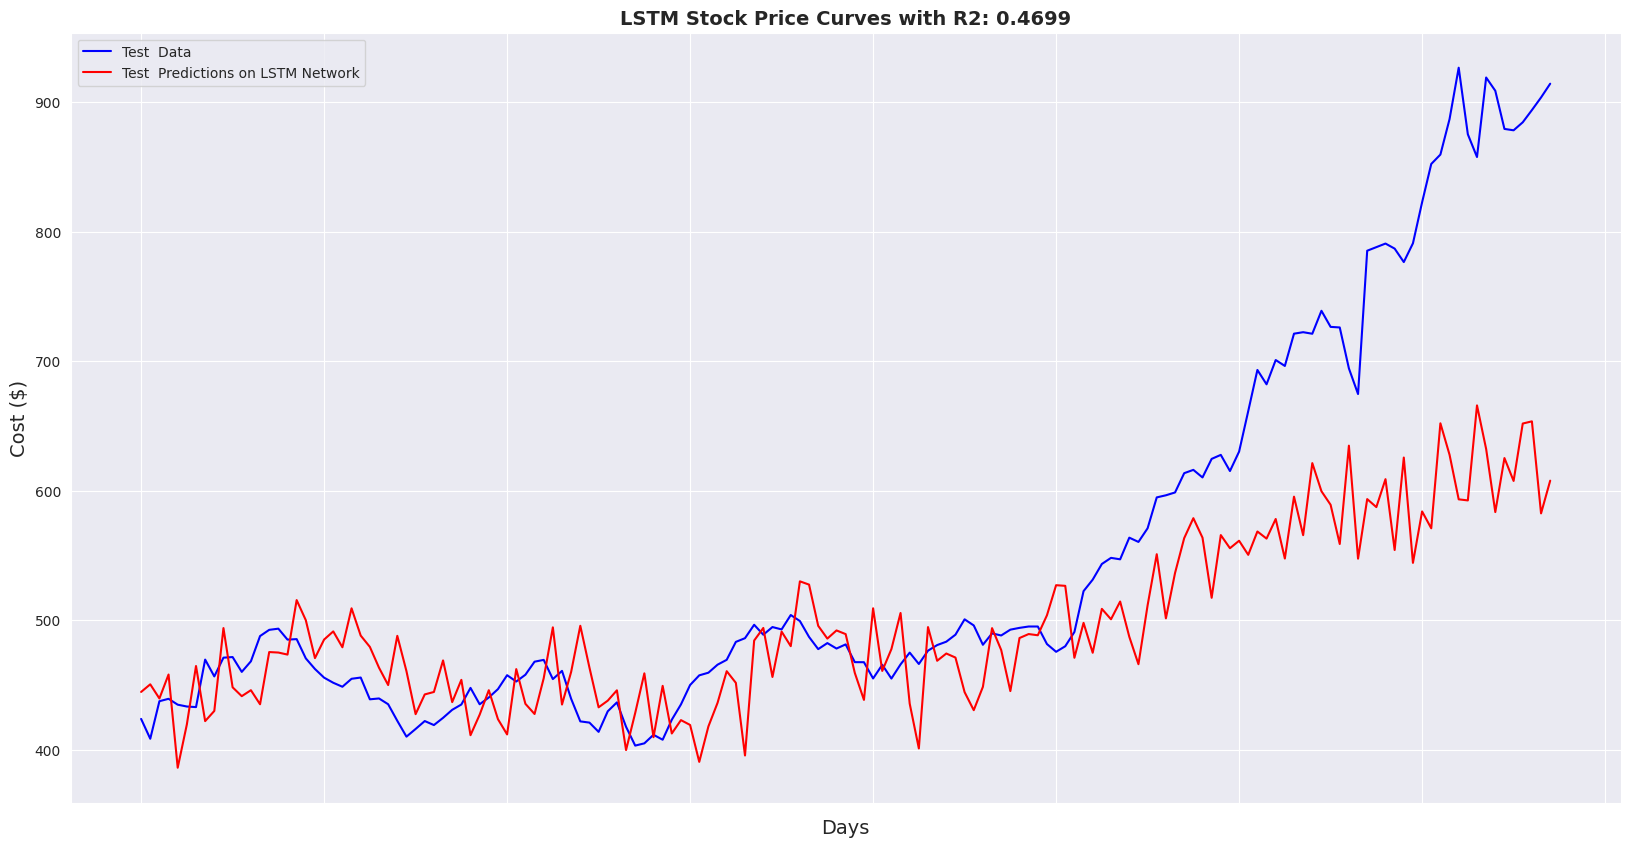

In [60]:
plot_predictions_vs_original("LSTM", test_set2, best_lstm_model, Xtest, Ytest)


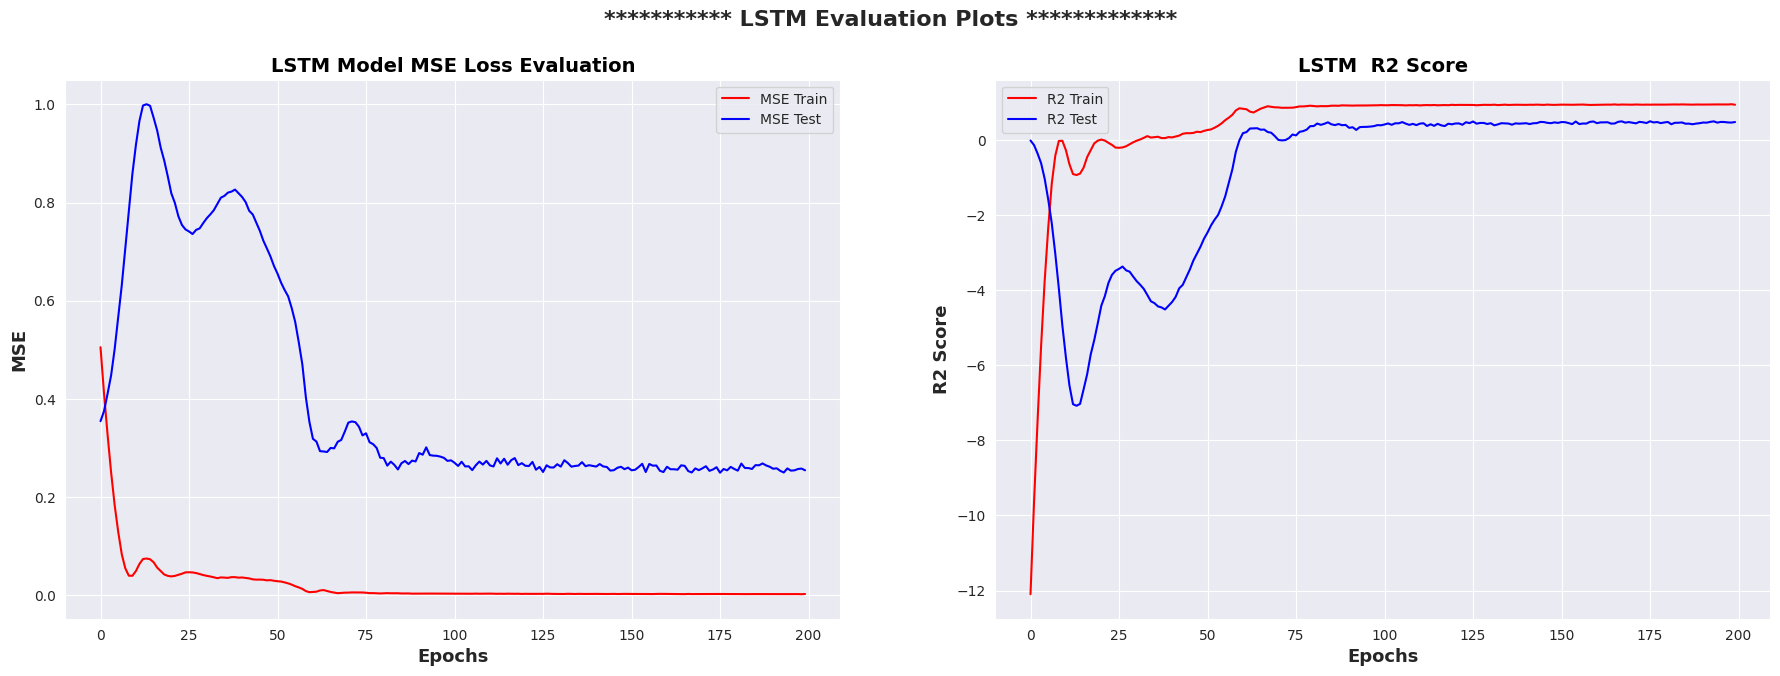

In [61]:
plot_loss_and_accuracy(history_lstm, "LSTM")
